Using TCC raster: C:\Users\bdevoe\Desktop\Greenspace\data\raw\TCC\2023\nlcd_tcc_CONUS_2023_v2023-5_wgs84\nlcd_tcc_conus_wgs84_v2023-5_20230101_20231231.tif
TCC CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
TCC nodata: 255.0
Computing TCC zonal stats...
Saved merged dataset -> C:\Users\bdevoe\Desktop\Greenspace\data\processed\tract_ndvi_evi_tcc_2021_2025.csv

=== Summary Statistics (tract-level) ===
          mean_ndvi      mean_evi      tc

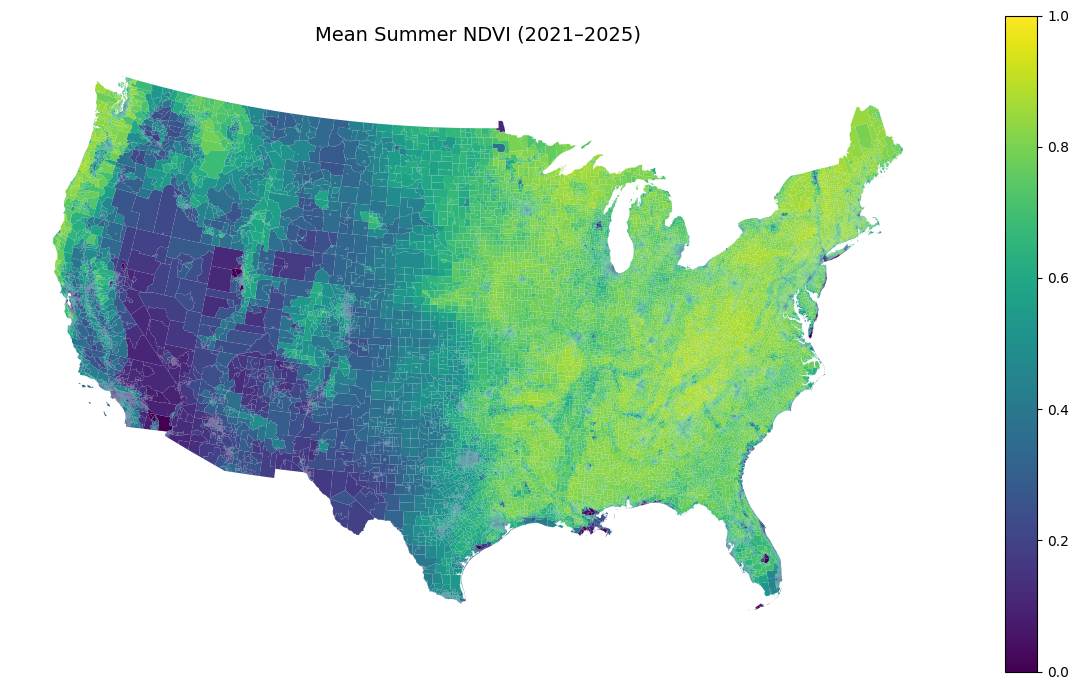

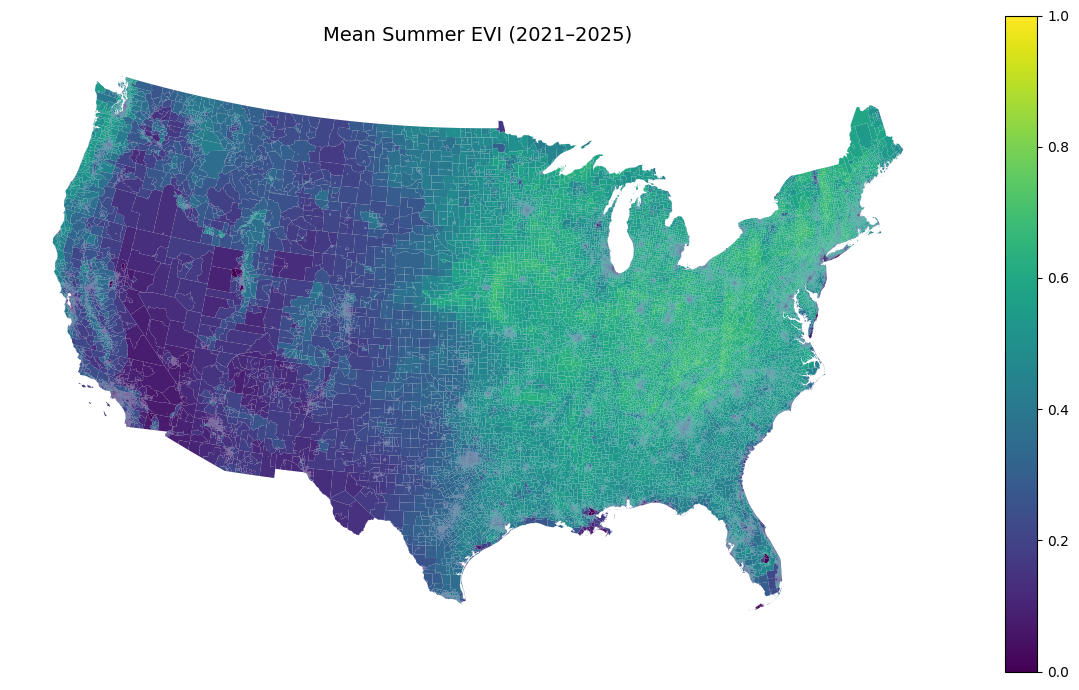

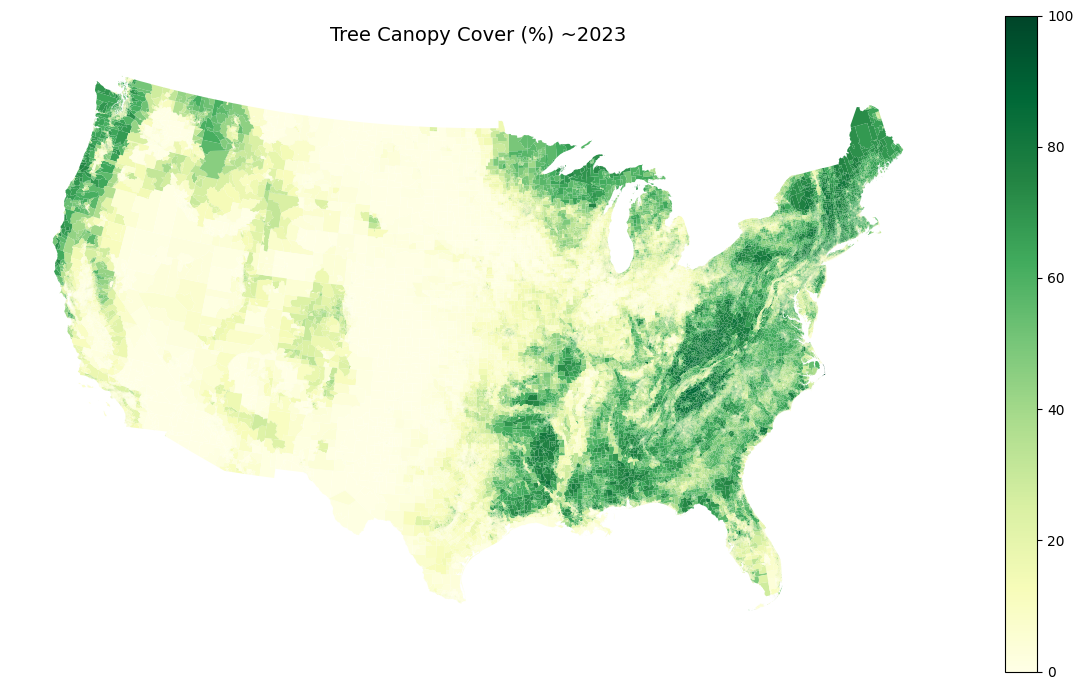

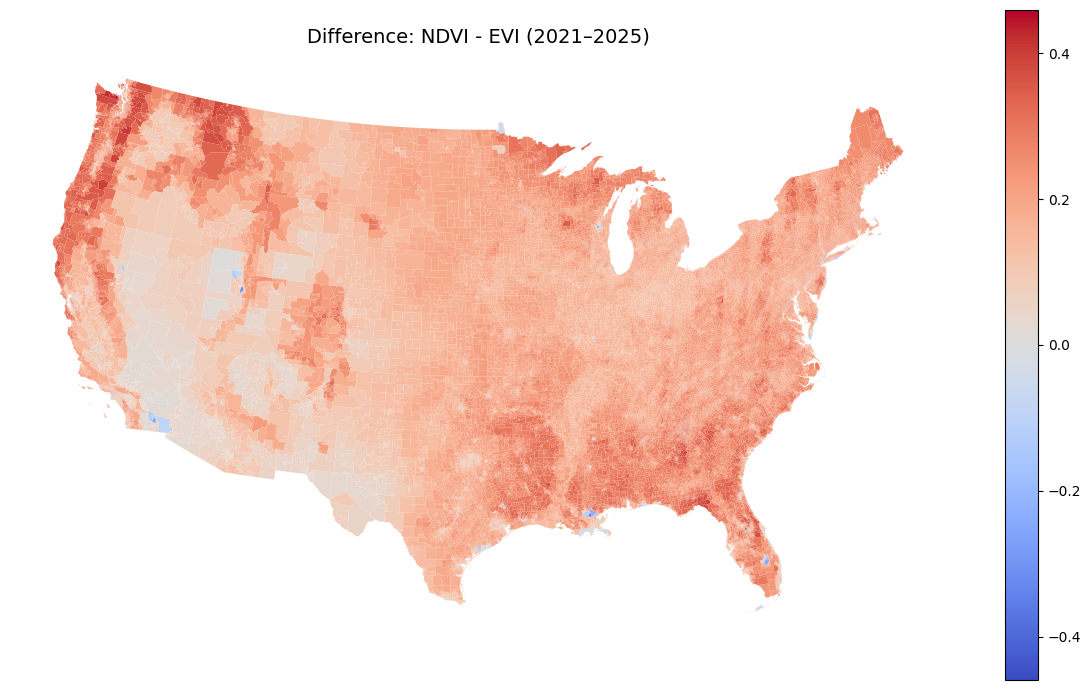

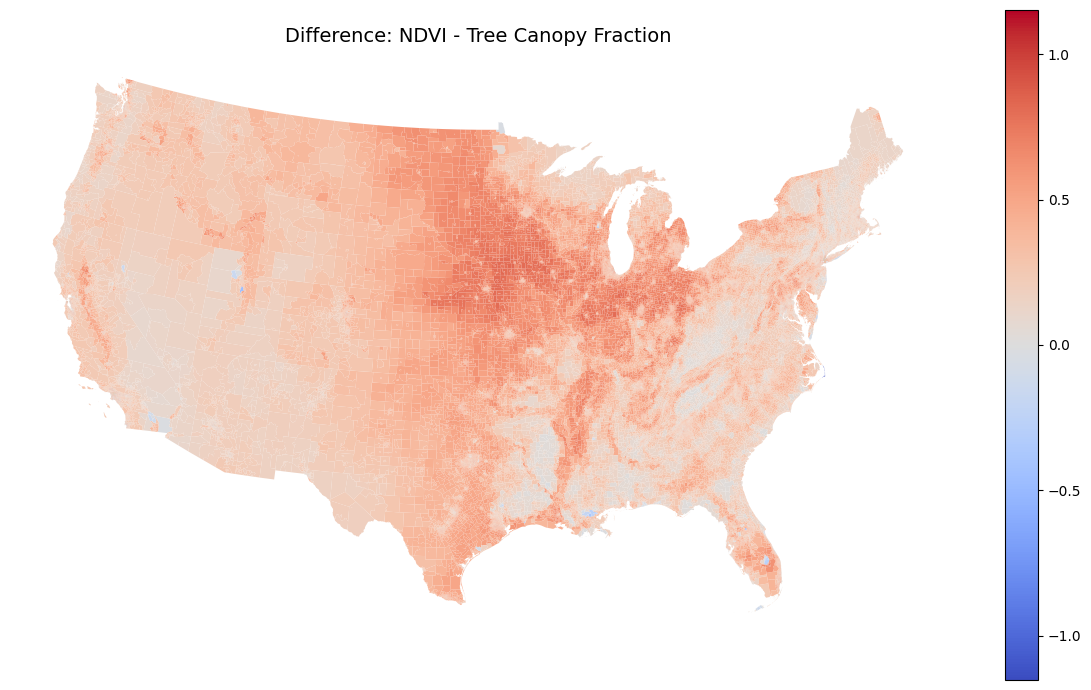

Done.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Paths
# ---------------------------------------------------------
REPO_ROOT = Path(r"C:\Users\bdevoe\Desktop\Greenspace")
PROCESSED = REPO_ROOT / "data" / "processed"
TRACTS_SHP = REPO_ROOT / "resources" / "cb_2020_us_tract_500k" / "cb_2020_us_tract_500k.shp"

YEAR_START = 2021
YEAR_END   = 2025

NDVI_CSV = PROCESSED / f"tract_ndvi_summer_{YEAR_START}_{YEAR_END}_summary.csv"
EVI_CSV  = PROCESSED / f"tract_evi_summer_{YEAR_START}_{YEAR_END}_summary.csv"

# TCC folder: now pointing into the named subdirectory you showed
TCC_DIR = REPO_ROOT / "data" / "raw" / "TCC" / "2023" / "nlcd_tcc_CONUS_2023_v2023-5_wgs84"
tcc_tifs = sorted(TCC_DIR.glob("*.tif"))
if not tcc_tifs:
    raise FileNotFoundError(f"No .tif found in {TCC_DIR}")
if len(tcc_tifs) > 1:
    print("Warning: multiple TCC tifs found, using the first one:")
    for p in tcc_tifs:
        print("  ", p.name)
TCC_TIF = tcc_tifs[0]
print("Using TCC raster:", TCC_TIF)

MERGED_CSV = PROCESSED / f"tract_ndvi_evi_tcc_{YEAR_START}_{YEAR_END}.csv"

# ---------------------------------------------------------
# 1. Load NDVI and EVI summaries
# ---------------------------------------------------------
ndvi = pd.read_csv(NDVI_CSV, dtype={"geoid": str})
evi  = pd.read_csv(EVI_CSV,  dtype={"geoid": str})

if "geometry" in evi.columns:
    evi = evi.drop(columns=["geometry"])

merged = ndvi.merge(evi, on="geoid", suffixes=("_ndvi", "_evi"))

# ---------------------------------------------------------
# 2. Convert to GeoDataFrame & reproject to TCC CRS
# ---------------------------------------------------------
gdf = gpd.GeoDataFrame(
    merged,
    geometry=gpd.GeoSeries.from_wkt(merged["geometry"]),
    crs="EPSG:4269"
)

with rasterio.open(TCC_TIF) as src:
    tcc_crs = src.crs
    tcc_nodata = src.nodata

print("TCC CRS:", tcc_crs)
print("TCC nodata:", tcc_nodata)

gdf = gdf.to_crs(tcc_crs)

# ---------------------------------------------------------
# 3. Zonal mean TCC per tract (0–100 %)
# ---------------------------------------------------------
print("Computing TCC zonal stats...")
zs = zonal_stats(
    gdf,
    TCC_TIF,
    stats=["mean"],
    nodata=tcc_nodata,
    all_touched=False,
)

gdf["tcc_mean"] = [z["mean"] for z in zs]
gdf["tcc_frac"] = gdf["tcc_mean"] / 100.0

# ---------------------------------------------------------
# 4. Save merged CSV
# ---------------------------------------------------------
gdf.to_csv(MERGED_CSV, index=False)
print(f"Saved merged dataset -> {MERGED_CSV}")

# ---------------------------------------------------------
# 5. Summary stats & correlations
# ---------------------------------------------------------
print("\n=== Summary Statistics (tract-level) ===")
print(gdf[["mean_ndvi", "mean_evi", "tcc_mean"]].describe())

print("\nCorrelation Matrix:")
print(gdf[["mean_ndvi", "mean_evi", "tcc_mean"]].corr())

# ---------------------------------------------------------
# 6. Comparison maps
# ---------------------------------------------------------
def plot_map(column, title, cmap="viridis", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(12, 7))
    gdf.plot(
        column=column,
        ax=ax,
        cmap=cmap,
        legend=True,
        linewidth=0,
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

plot_map("mean_ndvi", f"Mean Summer NDVI ({YEAR_START}–{YEAR_END})", vmin=0, vmax=1)
plot_map("mean_evi",  f"Mean Summer EVI ({YEAR_START}–{YEAR_END})", vmin=0, vmax=1)
plot_map("tcc_mean",  "Tree Canopy Cover (%) ~2023", cmap="YlGn", vmin=0, vmax=100)

gdf["ndvi_minus_evi"] = gdf["mean_ndvi"] - gdf["mean_evi"]
vmax_diff = np.nanmax(np.abs(gdf["ndvi_minus_evi"].to_numpy()))
plot_map(
    "ndvi_minus_evi",
    f"Difference: NDVI - EVI ({YEAR_START}–{YEAR_END})",
    cmap="coolwarm",
    vmin=-vmax_diff,
    vmax=vmax_diff,
)

gdf["ndvi_minus_tcc"] = gdf["mean_ndvi"] - gdf["tcc_frac"]
vmax_nt = np.nanmax(np.abs(gdf["ndvi_minus_tcc"].to_numpy()))
plot_map(
    "ndvi_minus_tcc",
    "Difference: NDVI - Tree Canopy Fraction",
    cmap="coolwarm",
    vmin=-vmax_nt,
    vmax=vmax_nt,
)

print("Done.")
